In [121]:
import os
import torch
import shutil
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, ToTensor, transforms
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.optim as optim
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Step 1. Create your custom dataset featuring 3 custom categories of at least 100 images each

In [122]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.images = []

        for index, _class in enumerate(self.classes):
            pathx = os.path.join(root_dir, _class)
            

            if os.path.isdir(pathx):
                for img in os.listdir(pathx):

                    # to ignore .DS_Store and non-image files
                    if img == '.DS_Store' or not img.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                        continue
                    
                    # appending the image onto dataset
                    self.images.append((os.path.join(pathx, img), index))
    

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        
        # this will returns tensors
        image = read_image(img_path)  
       
        # Python library for opening, manipulating, and saving various image formats.
        # tensor to PIL(Python Imaging Library) Image
        image = to_pil_image(image) 
        
        if self.transform:
            image = self.transform(image)
        return image, label

In [123]:
# image transformation for model traning 
transform = Compose([
    Resize((128, 128)),
    ToTensor(),
])

In [124]:
# Image data Loading
# Here Three types of fruites has been taken for training. Peach, Strawberry and pomogranate. 
# I have taken this three bcoz, it looks almost smilar, so it will help you evaluate model more accurately.

root_dir='./fruits'

dataset = CustomDataset(root_dir=root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [125]:
import pathlib
img_dir = "fruits/"
img_dir = pathlib.Path(img_dir)
total_img = len(list(img_dir.glob('*/*.jpg')))
print(total_img)

606


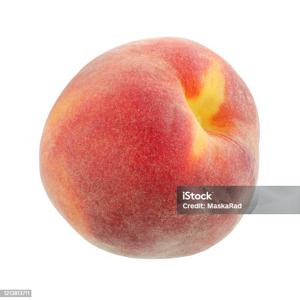

In [126]:
peaches = list(img_dir.glob('peaches/*'))
PIL.Image.open(str(peaches[9]))

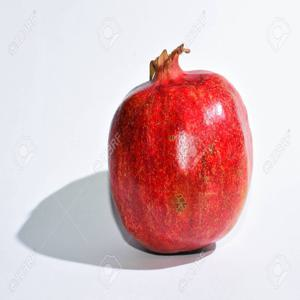

In [127]:
pomegranate = list(img_dir.glob('pomegranates/*'))
PIL.Image.open(str(pomegranate[9]))

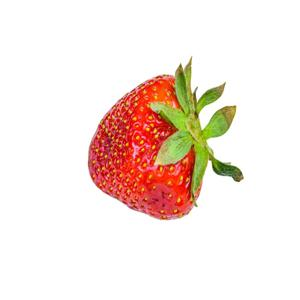

In [128]:
strawberry = list(img_dir.glob('strawberries/*'))
PIL.Image.open(str(strawberry[9]))

# Step 2. Split this data between 80% training and 20% test



In [129]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

dataset = ImageFolder(img_dir, transform = transform)

train_size = int(0.8 * len(dataset))  # 80% dataset size
test_size = len(dataset) - train_size  # 20% dataset size

train_dataset,  test_dataset = random_split(dataset, [train_size, test_size])

# Step 3. Preprocess the data as you see fit



In [130]:
class_names = dataset.classes
print(class_names)

train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

['peaches', 'pomegranates', 'strawberries']


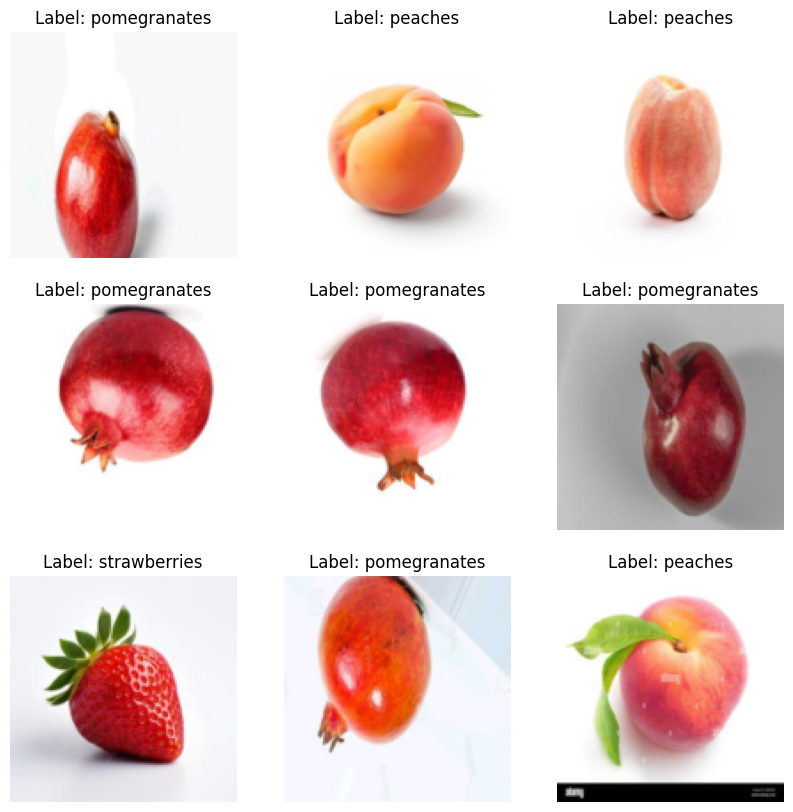

In [131]:
import torch
import torchvision
import matplotlib.pyplot as plt

data_iter = iter(train_dataloader)

# Fetching first batch of data
images, labels = next(data_iter)

# few fruit visualization
plt.figure(figsize=(10, 10))
for i in range(9):
    image = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {class_names[labels[i].item()]}")
    plt.axis("off")

plt.show()


# Step 4. Create a Convolutional Neural Network model to learn about your training set 



In [132]:
print(images.shape)

torch.Size([32, 3, 128, 128])


In [133]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        self.rescale = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),  # Rescaling layer, 1x1 conv
            nn.BatchNorm2d(3),  # Batch normalization to maintain scale
            nn.ReLU(inplace=True)
        )

        # stride=1 and
        # padding: without padding we might lose the information of the image


        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3,stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(64 * (img_height // 8) * (img_width // 8), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.rescale(x)
        x = self.conv1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.fc2(x)
        return x

# Define input dimensions
img_height, img_width = 128, 128

#  model Initialization
num_classes = 3
model = CustomModel(num_classes)

# Print the model architecture
print(model)


CustomModel(
  (rescale): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


In [134]:
loss_function = nn.CrossEntropyLoss()      # defining 'CrossEntropyLoss' Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)    # defining 'Adam' Optimizer

In [135]:
print(images.shape)

torch.Size([32, 3, 128, 128])


# Model Training 


In [136]:
# defining epochs to train model
num_epochs = 12

for epoch in range(num_epochs):

    # model training mode
    model.train()

    # defining loss 0 at starting
    running_curr__loss = 0.0

    for images, labels in train_dataloader:

        # Forward Propagation
        outputs = model(images)
        # defining loss function
        loss = loss_function(outputs, labels)

        # Before computing the gradients, we reset the existing gradients in the optimizer using zero.grad() & This is necessary because PyTorch accumulates gradients by default.
        optimizer.zero_grad()

        # Backward Propagation and optimize
        loss.backward()

        # This updates the model’s parameters using the gradients calculated in the previous step.
        optimizer.step()

        running_curr__loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_curr__loss/len(train_dataloader)}')


Epoch [1/12], Loss: 1.0870920941233635
Epoch [2/12], Loss: 0.9360316507518291
Epoch [3/12], Loss: 0.7476640716195107
Epoch [4/12], Loss: 0.616152822971344
Epoch [5/12], Loss: 0.5731224864721298
Epoch [6/12], Loss: 0.4636730011552572
Epoch [7/12], Loss: 0.332900021225214
Epoch [8/12], Loss: 0.19228936452418566
Epoch [9/12], Loss: 0.24291234510019422
Epoch [10/12], Loss: 0.3265441027469933
Epoch [11/12], Loss: 0.12776675820350647
Epoch [12/12], Loss: 0.09102232230361551


In [137]:
print(images.shape)

torch.Size([4, 3, 128, 128])


In [138]:
model.eval()
with torch.no_grad():
    correct_ans = 0
    total = 0
    print(images.shape)
    for images, labels in test_dataset:

        # checking for the dimentions, bcoz I got error of 3 dimensions
        if len(images.shape) == 3: 
            images = images.unsqueeze(0)  # Adding batch dimension

        if isinstance(labels, int):
            labels = torch.tensor([labels])  # Convert scalar to tensor

        output = model(images)
        _, predicted_val = torch.max(output.data, 1)
        total += labels.size(0)
        correct_ans += (predicted_val == labels).sum().item()

    print(f'Accuracy: {100 * correct_ans / total}%')

torch.Size([4, 3, 128, 128])
Accuracy: 77.8688524590164%


In [139]:
print(images.shape)

torch.Size([1, 3, 128, 128])


# Step 5. Make predictions on the test data and compare them to the expected categories



In [140]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F
import numpy as np

# size of the image
img_height = 128  
img_width = 128  

# Testing image path
img_path = 'fruits/peaches/peach_100.jpg'
img = Image.open(img_path).convert('RGB')

# Transformation of the image
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

img_tensor = transform(img)

img_tensor = img_tensor.unsqueeze(0)

# keeping model in evalution mode
model.eval() 

with torch.no_grad():
    inputs = img_tensor
    outputs = model(inputs) 
    _, predicted = torch.max(outputs, 1)

    # Convert logits to probabilities using softmax
    probabilities = F.softmax(outputs, dim=1)
    score = probabilities.cpu().detach().numpy()

    print(
        "Fruit is define as {} with a {:.2f} % confidence."
        .format(class_names[predicted.item()], 100 * np.max(score))
    )


Fruit is define as pomegranates with a 81.67 % confidence.


# Step 6: Use GoogleNet(InceptionNet) and add a LinearLayer on top of it.



In [141]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


dataset = ImageFolder(img_dir, transform = transform)

train_size = int(0.8 * len(dataset))  #  80% of training dataset
val_size = len(dataset) - train_size  #  20% of testing dataset 

train_dataset,  test_dataset = random_split(dataset, [train_size, val_size])

class_names = dataset.classes
print(class_names)

train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

['peaches', 'pomegranates', 'strawberries']


In [142]:
num_classes = 12

googlenet = models.googlenet(pretrained=True)

# freezing all parameters while training the final layer.
for param in googlenet.parameters():
    param.requires_grad = False

# Linear layer
googlenet.fc = nn.Linear(googlenet.fc.in_features, num_classes) 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Step 7: Train the GoogleNet model and compare the accuracy with the first model.

In [143]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet.fc.parameters(), lr=0.001)

num_epochs = 12

for epoch in range(num_epochs):
    googlenet.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_dataloader:

        optimizer.zero_grad()

        # Forward Propagation
        outputs = googlenet(inputs)
        loss = criterion(outputs, labels)

        #  accuracy calculation of the model
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Backward Propagation 
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculating the AVG loss and accuracy
    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = (correct_predictions / total_predictions) * 100

    # Printing accuracy of the GoogleNet Model
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

Epoch 1/12, Loss: 1.2520, Accuracy: 44.01%
Epoch 2/12, Loss: 0.6834, Accuracy: 84.50%
Epoch 3/12, Loss: 0.4811, Accuracy: 91.94%
Epoch 4/12, Loss: 0.3713, Accuracy: 94.42%
Epoch 5/12, Loss: 0.3079, Accuracy: 95.04%
Epoch 6/12, Loss: 0.2571, Accuracy: 96.28%
Epoch 7/12, Loss: 0.2264, Accuracy: 96.49%
Epoch 8/12, Loss: 0.1953, Accuracy: 97.73%
Epoch 9/12, Loss: 0.1876, Accuracy: 97.31%
Epoch 10/12, Loss: 0.1770, Accuracy: 97.52%
Epoch 11/12, Loss: 0.1605, Accuracy: 96.90%
Epoch 12/12, Loss: 0.1493, Accuracy: 97.52%


In [144]:
# Model Evalution
googlenet.eval()
correct_ans = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = googlenet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct_ans += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct_ans / total}%')


Accuracy: 98.36065573770492%


# For Regular CNN Model 84.42% accuracy has been achived, while googleNet Model 98.36% accuracy has been received.